In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from random import choice
import pickle
from tqdm import tqdm
import xgboost as xgb
import os
from sklearn.ensemble import ExtraTreesRegressor
from fbprophet import Prophet
import json
from fbprophet.serialize import model_to_json, model_from_json

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
#load Train and Test Data
train_df_final = pd.read_csv('train_all_features.csv')
test_df_final = pd.read_csv('test_all_features.csv')


In [4]:
avg_sales = train_df_final.groupby(['Store'])[['Weekly_Sales']].mean().reset_index()
avg_sales.head()

,Store,Weekly_Sales
0,1,21710.543621
1,2,26898.070031
2,3,6373.033983
3,4,29161.210415
4,5,5053.415813


In [6]:
avg_sales.to_csv('avg_sales.csv',index=False)

In [7]:
avg_sales = pd.read_csv('avg_sales.csv')
avg_sales.head()

,Store,Weekly_Sales
0,1,21710.543621
1,2,26898.070031
2,3,6373.033983
3,4,29161.210415
4,5,5053.415813


In [15]:
test_df_final.shape

(115064, 17)

In [3]:
test_df_final.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Week_Of_Month,Week,Days_to_Christmas,A,B,C
0,1,1,False,151315,55.32,3.386,223.462779,6.573,2012,11,2,1.0,44,53,1,0,0
1,1,2,False,151315,55.32,3.386,223.462779,6.573,2012,11,2,1.0,44,53,1,0,0
2,1,3,False,151315,55.32,3.386,223.462779,6.573,2012,11,2,1.0,44,53,1,0,0
3,1,4,False,151315,55.32,3.386,223.462779,6.573,2012,11,2,1.0,44,53,1,0,0
4,1,5,False,151315,55.32,3.386,223.462779,6.573,2012,11,2,1.0,44,53,1,0,0


In [3]:
train_df_final.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Week_Of_Month,Week,Days_to_Christmas,A,B,C
0,1,1,24924.50,False,151315,42.31,2.572,211.096358,8.106,2010,2,5,1.0,5,323,1,0,0
1,35,3,14612.19,False,103681,27.19,2.784,135.352461,9.262,2010,2,5,1.0,5,323,0,1,0
2,35,4,26323.15,False,103681,27.19,2.784,135.352461,9.262,2010,2,5,1.0,5,323,0,1,0
3,35,5,36414.63,False,103681,27.19,2.784,135.352461,9.262,2010,2,5,1.0,5,323,0,1,0
4,35,6,11437.81,False,103681,27.19,2.784,135.352461,9.262,2010,2,5,1.0,5,323,0,1,0


In [17]:
distinct_store_dept =  train_df_final[['Store','Dept']].drop_duplicates().values.tolist()
len(distinct_store_dept)

3331

In [18]:
def calculate_WMAE(dt, y , yHat):
    '''
        This is the method to calculate Performance metric
    '''    
    w = dt['IsHoliday'].apply(lambda x : 5 if x else 1)
    return np.round(np.sum(w*abs(y-yHat))/np.sum(w),4)

In [19]:
train_df_final['Weekly_Sales'] = train_df_final['Weekly_Sales'].apply(lambda x : x if x>0.0 else 0)

In [4]:
df_wmae = pd.read_csv('All_model_details.csv')
df_wmae.shape

(12908, 5)

In [5]:
sb = pd.DataFrame({
  'holiday' : 'superbowl',
  'ds' : pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08'])
  })

lb = pd.DataFrame({
  'holiday' : 'laborday',
  'ds' : pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07','2013-09-06'])
  })

tg = pd.DataFrame({
  'holiday' : 'thanksgiving',
  'ds' : pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23','2013-11-29'])
  })

cm = pd.DataFrame({
  'holiday' : 'christmas',
  'ds' : pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28','2013-12-27'])
  })

holidays = pd.concat((sb, lb, tg, cm))
holidays.head(20)

,holiday,ds
0,superbowl,2010-02-12
1,superbowl,2011-02-11
2,superbowl,2012-02-10
3,superbowl,2013-02-08
0,laborday,2010-09-10
1,laborday,2011-09-09
2,laborday,2012-09-07
3,laborday,2013-09-06
0,thanksgiving,2010-11-26
1,thanksgiving,2011-11-25


In [26]:

columns = ['Store','Dept','ModelName','wmae_score','ModelType','Version']
df_wmae = pd.DataFrame(columns=columns)

if os.path.isfile('All_model_details.csv'):
    df_wmae = pd.read_csv('All_model_details.csv')

df_wmae['Version'] = 1
v = 2

for s, d in tqdm(distinct_store_dept):
    #Filter the data
    curr_Store_Dept = train_df_final[(train_df_final['Store'] == s) & (train_df_final['Dept'] == d)]
    curr_Store_Dept_X = curr_Store_Dept.drop(['Weekly_Sales','Store','Dept'], axis = 1)
    curr_Store_Dept_Y = curr_Store_Dept['Weekly_Sales']
    
    
    if curr_Store_Dept_X.shape[0]>=5 :
        
        curr_X_Train, curr_X_Test, Y_train, Y_test = train_test_split(curr_Store_Dept_X,curr_Store_Dept_Y, test_size=0.20)
        
        
        #Train a Random Forest Model
        model, par, wmae = train_RandomForestModel(curr_X_Train,curr_X_Test,Y_train,Y_test)
        
        filename = 'Models/RandomForest/RF_'+str(s)+'_'+str(d)+'V'+str(v)+'.pkl'

        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        
        df = pd.DataFrame([[s,d,filename,wmae,'RF',v]], columns = columns)
        df_wmae = df_wmae.append(df, ignore_index=True)
        
        #Train a XGBOOST Model
        model, par, wmae = train_XGBoostModel(curr_X_Train,curr_X_Test,Y_train,Y_test)
        
        filename = 'Models/XGBoost/XGB_'+str(s)+'_'+str(d)+'V'+str(v)+'.pkl'

        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        
        df = pd.DataFrame([[s,d,filename,wmae,'XGB',v]], columns = columns)
        df_wmae = df_wmae.append(df, ignore_index=True)
    
        
        
        #Train a ExtraTreesRegressor model
        model, par, wmae = train_RandomForestModel(curr_X_Train,curr_X_Test,Y_train,Y_test)
        
        filename = 'Models/XtraTrees/ET_'+str(s)+'_'+str(d)+'V'+str(v)+'.pkl'

        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        
        df = pd.DataFrame([[s,d,filename,wmae,'ET',v]], columns = columns)
        df_wmae = df_wmae.append(df, ignore_index=True)
        
        
        
        #Prophet
        
        model,wmae = train_ProphetModel(curr_Store_Dept, holidays)
        filename = 'Models/Prophet/PP_'+str(s)+'_'+str(d)+'V'+str(v)+'.json'
        
        with open(filename, 'w') as file:
            json.dump(model_to_json(model), file)  # Save model
        
        df = pd.DataFrame([[s,d,filename,wmae,'PP',v]], columns = columns)
        df_wmae = df_wmae.append(df, ignore_index=True)

df_wmae.to_csv('All_model_details.csv',index=False)       
        

 89%|█████████████████████████████████████████████████████████████████▊        | 2965/3331 [3:29:14<1:02:25, 10.23s/it]INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


 92%|███████████████████████████████████████████████████████████████████▊      | 3054/3331 [3:41:52<1:05:16, 14.14s/it]INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


 95%|████████████████████████████████████████████████████████████████████████▏   | 3164/3331 [3:54:16<12:21,  4.44s/it]INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3274/3331 [4:01:15<02:43,  2.88s/it]INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


100%|████████████████████████████████████████████████████████████████████████████| 3331/3331 [4:04:39<00:00,  4.41s/it]


## Function to train a Prophet Model

In [21]:
def calculate_WMAE_different(dt):
    '''
        This is the method to calculate Performance metric
    '''    
    dt['w'] = dt['IsHoliday'].apply(lambda x : 5 if x else 1)
    dt['error'] = dt.apply(lambda x : abs(x['yhat']-x['Weekly_Sales'])*x['w'], axis=1)
    return np.round(np.sum(dt['error'])/np.sum(dt['w']),4), dt

In [22]:
def train_ProphetModel(train_Data, holidays):
    train_Data['Month'] = train_Data['Month'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))
    train_Data['Day'] = train_Data['Day'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))
    train_Data['Date'] = train_Data.apply(lambda x: str(x['Year'])+"-"+str(x['Month'])+"-"+str(x['Day']), axis=1)
    train_Data['Date'] = pd.to_datetime(train_Data['Date'])
    
    prophrt_data = train_Data[['Date', 'Weekly_Sales']]
    prophrt_data = prophrt_data.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
    
    prophet = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    prophet.fit(prophrt_data)
    
    df_forecast = prophrt_data[['ds']]
    df_yHat = prophet.predict(df_forecast)
    train_Data = train_Data.merge(df_yHat[['ds', 'yhat']],left_on='Date', right_on='ds')
    
    s,_ = calculate_WMAE_different(train_Data)
    
    return prophet, s

### Function to train a Random Forest model

In [23]:
def train_RandomForestModel(train_X,test_X, train_y, test_y):
    
    #Hyper parameter for the random forest
    RF_HF = dict(n_estimators=[10,20,30,40,50,60,75],
            max_depth=[3,5,7,9,11,15],
            max_features = [2,3,4,5,6,7,8,9],
            min_samples_split = [2,3,4],
            min_samples_leaf = [1,2,3])
    columns = ['n_estimators','max_depth','max_features','min_samples_split','min_samples_leaf','wmae_score']
    wmae_df = pd.DataFrame(columns=columns)
    for i in range(20):
        
        #Selecting some random hyper Parameter
        esti = choice(RF_HF['n_estimators'])
        md = choice(RF_HF['max_depth'])
        mf = choice(RF_HF['max_features'])
        mss = choice(RF_HF['min_samples_split'])
        msl = choice(RF_HF['min_samples_leaf'])
        
        #Initialize the model
        rf = RandomForestRegressor(n_estimators=esti
                              ,max_depth=md
                               ,max_features = mf
                               ,min_samples_split = mss
                               ,min_samples_leaf = msl
                               ,n_jobs=-1)
        
        #Train the Random Forest model
        rf.fit(train_X,train_y)
        y_hat = rf.predict(test_X)
        wmae_score = calculate_WMAE(test_X,test_y,y_hat)
        
        df = pd.DataFrame([[esti,md, mf,mss,msl,wmae_score]], columns = columns)
        wmae_df = wmae_df.append(df, ignore_index=True)
        
    wmae_df = wmae_df.sort_values('wmae_score').reset_index()
    
    #Train the model with best hyper parameter
    rf = RandomForestRegressor(n_estimators=wmae_df.iloc[0]['n_estimators']
                              ,max_depth=wmae_df.iloc[0]['max_depth']
                               ,max_features = wmae_df.iloc[0]['max_features']
                               ,min_samples_split = wmae_df.iloc[0]['min_samples_split']
                               ,min_samples_leaf = wmae_df.iloc[0]['min_samples_leaf']
                               ,n_jobs=-1)
    
    #train the model with all data
    X = train_X.append(test_X, ignore_index=True)    
    Y = train_y.append(test_y, ignore_index=True)
    
    rf.fit(X,Y)
    
    #Parameter Dictionary
    par= dict()
    par['n_estimators'] = wmae_df.iloc[0]['n_estimators']
    par['max_depth'] = wmae_df.iloc[0]['max_depth']    
    par['max_features'] = wmae_df.iloc[0]['max_features']    
    par['min_samples_split'] = wmae_df.iloc[0]['min_samples_split']    
    par['min_samples_leaf'] = wmae_df.iloc[0]['min_samples_leaf']   
    
    wmae = calculate_WMAE(X,Y, rf.predict(X))
    
    return rf,par,wmae

### Function to train a XGBoost Model

In [24]:
def train_XGBoostModel(train_X,test_X, train_y, test_y):
    
    #Hyper parameter for the random forest
    XGB_HF = dict(n_estimators=[10,20,30,40,50,60,75],
            max_depth=[2,3,5,7,9,11,15],
            learning_rate = [0.001,0.003,0.01,0.03,0.1])
    
    columns = ['n_estimators','max_depth','learning_rate','wmae_score']
    wmae_df = pd.DataFrame(columns=columns)
    
    for i in range(20):
        
        #Selecting some random hyper Parameter
        esti = choice(XGB_HF['n_estimators'])
        md = choice(XGB_HF['max_depth'])
        lr = choice(XGB_HF['learning_rate'])
        
        #Initialize the model
        rf = xgb.XGBRegressor(n_estimators=esti
                              ,max_depth=md
                               ,learning_rate = lr
                               ,n_jobs=-1)
        
        #Train the Random Forest model
        rf.fit(train_X,train_y)
        y_hat = rf.predict(test_X)
        wmae_score = calculate_WMAE(test_X,test_y,y_hat)
        
        df = pd.DataFrame([[esti,md, lr,wmae_score]], columns = columns)
        wmae_df = wmae_df.append(df, ignore_index=True)
        
    wmae_df = wmae_df.sort_values('wmae_score').reset_index()
    
    #Train the model with best hyper parameter
    
    rf = xgb.XGBRegressor(n_estimators=wmae_df.iloc[0]['n_estimators']
                              ,max_depth=wmae_df.iloc[0]['max_depth']
                               ,learning_rate = wmae_df.iloc[0]['learning_rate']
                               ,n_jobs=-1)
    
    #train the model with all data
    X = train_X.append(test_X, ignore_index=True)    
    Y = train_y.append(test_y, ignore_index=True)
    
    rf.fit(X,Y)
    
    #Parameter Dictionary
    par= dict()
    par['n_estimators'] = wmae_df.iloc[0]['n_estimators']
    par['max_depth'] = wmae_df.iloc[0]['max_depth']    
    par['learning_rate'] = wmae_df.iloc[0]['learning_rate']    
    
    wmae = calculate_WMAE(X,Y, rf.predict(X))
    
    return rf,par,wmae

### Function to train a ExtraTreesRegressor Model

In [25]:
def train_ExtraTreesRegressorModel(train_X,test_X, train_y, test_y):
    
    #Hyper parameter for the Extra Trees
    ET_HF = dict(n_estimators=[10,20,30,40,50,60,75],
            max_depth=[3,5,7,9,11,15],
            max_features = [2,3,4,5,6,7,8,9],
            min_samples_split = [2,3,4],
            min_samples_leaf = [1,2,3])
    columns = ['n_estimators','max_depth','max_features','min_samples_split','min_samples_leaf','wmae_score']
    wmae_df = pd.DataFrame(columns=columns)
    for i in range(20):
        
        #Selecting some random hyper Parameter
        esti = choice(ET_HF['n_estimators'])
        md = choice(ET_HF['max_depth'])
        mf = choice(ET_HF['max_features'])
        mss = choice(ET_HF['min_samples_split'])
        msl = choice(ET_HF['min_samples_leaf'])
        
        #Initialize the model
        rf = ExtraTreesRegressor(n_estimators=esti
                              ,max_depth=md
                               ,max_features = mf
                               ,min_samples_split = mss
                               ,min_samples_leaf = msl
                               ,n_jobs=-1)
        
        #Train the Extra Trees model
        rf.fit(train_X,train_y)
        y_hat = rf.predict(test_X)
        wmae_score = calculate_WMAE(test_X,test_y,y_hat)
        
        df = pd.DataFrame([[esti,md, mf,mss,msl,wmae_score]], columns = columns)
        wmae_df = wmae_df.append(df, ignore_index=True)
        
    wmae_df = wmae_df.sort_values('wmae_score').reset_index()
    
    #Train the model with best hyper parameter
    rf = ExtraTreesRegressor(n_estimators=wmae_df.iloc[0]['n_estimators']
                              ,max_depth=wmae_df.iloc[0]['max_depth']
                               ,max_features = wmae_df.iloc[0]['max_features']
                               ,min_samples_split = wmae_df.iloc[0]['min_samples_split']
                               ,min_samples_leaf = wmae_df.iloc[0]['min_samples_leaf']
                               ,n_jobs=-1)
    
    #train the model with all data
    X = train_X.append(test_X, ignore_index=True)    
    Y = train_y.append(test_y, ignore_index=True)
    
    rf.fit(X,Y)
    
    #Parameter Dictionary
    par= dict()
    par['n_estimators'] = wmae_df.iloc[0]['n_estimators']
    par['max_depth'] = wmae_df.iloc[0]['max_depth']    
    par['max_features'] = wmae_df.iloc[0]['max_features']    
    par['min_samples_split'] = wmae_df.iloc[0]['min_samples_split']    
    par['min_samples_leaf'] = wmae_df.iloc[0]['min_samples_leaf']   
    
    wmae = calculate_WMAE(X,Y, rf.predict(X))
    
    return rf,par,wmae

In [6]:
df_wmae = pd.read_csv('All_model_details.csv')
df_wmae.shape

(25816, 6)

In [6]:
df_wmae.sort_values(['Store','Dept','ModelName']).head(20)

,Store,Dept,ModelName,wmae_score,ModelType,Version
9681,1,1,Models/Prophet/PP_1_1V1.json,2976.4360,PP,1
12911,1,1,Models/Prophet/PP_1_1V2.json,2976.4360,PP,2
0,1,1,Models/RandomForest/RF_1_1V1.pkl,1597.2834,RF,1
12908,1,1,Models/RandomForest/RF_1_1V2.pkl,2309.3365,RF,2
1,1,1,Models/XGBoost/XGB_1_1V1.pkl,2700.0926,XGB,1
12909,1,1,Models/XGBoost/XGB_1_1V2.pkl,1535.7139,XGB,2
6454,1,1,Models/XtraTrees/ET_1_1V1.pkl,1779.6401,ET,1
12910,1,1,Models/XtraTrees/ET_1_1V2.pkl,1727.0049,ET,2
12612,1,2,Models/Prophet/PP_1_2V1.json,1794.3908,PP,1
24635,1,2,Models/Prophet/PP_1_2V2.json,1794.3908,PP,2


In [11]:
store_data = pd.read_csv("stores.csv")
store_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [32]:
df_wmae.sort_values('Version',ascending=False).head()

,Store,Dept,ModelName,wmae_score,ModelType,Version
12908,1,1,Models/RandomForest/RF_1_1V2.pkl,2309.3365,RF,2
17208,41,82,Models/RandomForest/RF_41_82V2.pkl,2400.5203,RF,2
17218,41,80,Models/XtraTrees/ET_41_80V2.pkl,350.8657,ET,2
17217,41,80,Models/XGBoost/XGB_41_80V2.pkl,1814.8366,XGB,2
17216,41,80,Models/RandomForest/RF_41_80V2.pkl,500.5948,RF,2


In [39]:
avg_sales = train_df_final.groupby(['Store','Dept'])[['Weekly_Sales']].mean().reset_index()
avg_sales[(avg_sales['Store'] == 5) & (avg_sales['Dept'] == 1)].reset_index()[['Store']].iloc[0,0]

5

In [12]:
def get_nearestStore(store, field, model_info='sales'):
    '''
        This is a function which will give us similar store in term of Field. 
        By default it will give us the nearest store based on the weekly sales
    '''
    avg_sales = train_df_final.groupby(['Store'])[['Weekly_Sales']].mean().reset_index()
    if field == 'size':
        avg_sales = train_df_final.groupby(['Store'])[['Size']].mean().reset_index()
        
    
    avg_sales['ABS_Diff'] = abs(avg_sales.iloc[:,1] - avg_sales[avg_sales['Store'] == store].reset_index().iloc[0,1])
    
    avg_sales = avg_sales.merge(model_info, on='Store')
    alt_store = avg_sales[avg_sales['Store'] != store].reset_index()[['Store']].iloc[0,0]
    
    return int(alt_store);
    
    

In [9]:
def predict_Sales_test_data(df_models, test_X,store_info, useAllModel=True, modelName=None, useBestModel=False, altModel = 'sale', version=None):
    '''
    This is function to predict the sales
    '''
    
    return_df = test_X.copy(True)
    return_df = return_df.set_index(['Store','Dept','Day','Month','Year'])
    
    #print(return_df.columns)
    distinct_store_dept =  test_X[['Store','Dept']].drop_duplicates().values.tolist()
    
    df_models = df_models.merge(store_info, on='Store')
    
    df_calculated = pd.DataFrame(columns=test_X.columns)
    
    for s,d in tqdm(distinct_store_dept):
        
        
        curr_Store_Dept = test_X[(test_X['Store'] == s) & (test_X['Dept'] == d)]
        
        curr_Store_Dept_X = curr_Store_Dept.drop(['Store','Dept'], axis = 1)
        
        #df_curr_row = pd.DataFrame([curr_row]).drop(['Store','Dept'], axis=1)
        sale_for_curr_dept = df_models[df_models['Dept'] == d]
        
        #Use Models Specified 
        if useAllModel is False:
            modelTypeArray = modelName.split(',')
            sale_for_curr_dept = sale_for_curr_dept[sale_for_curr_dept['ModelType'].isin(modelTypeArray)]
            
        if version is not None:
            sale_for_curr_dept = sale_for_curr_dept[sale_for_curr_dept['Version'] == version]
        
        sale_for_curr_dept_store = sale_for_curr_dept[sale_for_curr_dept['Store']==s].reset_index()
        
        curr_Store_Dept['Weekly_Sales'] = 0.0;
        
        if sale_for_curr_dept_store.shape[0]>0:
            
            if useBestModel is True:
                sale_for_curr_dept_store = sale_for_curr_dept_store.sort_values('wmae_score').reset_index().iloc[0:1,:]
            
            for modelsName in sale_for_curr_dept_store['ModelName']:
                if 'PP' in modelsName:
                    with open(modelsName, 'r') as file:
                        pickle_model = model_from_json(json.load(file))  # Load model
                        
                        curr_Store_Dept['Month1'] = curr_Store_Dept['Month'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))
                        curr_Store_Dept['Day1'] = curr_Store_Dept['Day'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))
                        curr_Store_Dept['ds'] = curr_Store_Dept.apply(lambda x: str(x['Year'])+"-"+str(x['Month1'])+"-"+str(x['Day1']), axis=1)
                        curr_Store_Dept['ds'] = pd.to_datetime(curr_Store_Dept['ds'])
                        
                        prophet_data = curr_Store_Dept[['ds']]
                        
                        p = pickle_model.predict(prophet_data)
                        
                        curr_Store_Dept = curr_Store_Dept.merge(p[['ds', 'yhat']], left_on='ds', right_on='ds')
                        
                        curr_Store_Dept["Weekly_Sales"] = curr_Store_Dept["Weekly_Sales"] + curr_Store_Dept["yhat"]
                        
                        curr_Store_Dept = curr_Store_Dept.drop(['yhat','Month1','Day1','ds'], axis=1)
                        
                else:
                    with open(modelsName, 'rb') as file:
                        pickle_model = pickle.load(file)            
                        curr_Store_Dept['Weekly_Sales'] += pickle_model.predict(curr_Store_Dept_X)
                
            curr_Store_Dept['Weekly_Sales'] = curr_Store_Dept['Weekly_Sales']/sale_for_curr_dept_store.shape[0]
            
            df_calculated = df_calculated.append(curr_Store_Dept, ignore_index=True)
            #df = curr_Store_Dept[['Store','Dept','Day','Month','Year','Weekly_Sales']].set_index(['Store','Dept','Day','Month','Year'])
            #print(df.columns)
            #return_df = return_df.join(df,lsuffix='l',rsuffix='r')
        else:
            #If we don't find any models for curr store and dept then we will predict the sale for the store 
            #which has similar size for same dept
            
            alt_store = get_nearestStore(s, altModel, sale_for_curr_dept)
            
            sale_for_curr_dept_store = sale_for_curr_dept[sale_for_curr_dept['Store']==alt_store].reset_index()
            
            if useBestModel is True:
                sale_for_curr_dept_store = sale_for_curr_dept_store.sort_values('wmae_score').reset_index().iloc[0:1,:]
            
            for modelsName in sale_for_curr_dept_store['ModelName']:
                
                if 'PP' in modelsName:
                    with open(modelsName, 'r') as file:
                        pickle_model = model_from_json(json.load(file))  # Load model
                        
                        curr_Store_Dept['Month1'] = curr_Store_Dept['Month'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))
                        curr_Store_Dept['Day1'] = curr_Store_Dept['Day'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))
                        curr_Store_Dept['ds'] = curr_Store_Dept.apply(lambda x: str(x['Year'])+"-"+str(x['Month1'])+"-"+str(x['Day1']), axis=1)
                        curr_Store_Dept['ds'] = pd.to_datetime(curr_Store_Dept['ds'])
                        
                        prophet_data = curr_Store_Dept[['ds']]
                        
                        p = pickle_model.predict(prophet_data)
                        
                        curr_Store_Dept = curr_Store_Dept.merge(p[['ds', 'yhat']], left_on='ds', right_on='ds')
                        
                        curr_Store_Dept["Weekly_Sales"] = curr_Store_Dept["Weekly_Sales"] + curr_Store_Dept["yhat"]
                        
                        curr_Store_Dept = curr_Store_Dept.drop(['yhat','Month1','Day1','ds'], axis=1)
                        
                else:
                    with open(modelsName, 'rb') as file:
                        pickle_model = pickle.load(file)
                        curr_Store_Dept['Weekly_Sales'] += pickle_model.predict(curr_Store_Dept_X)
                
            curr_Store_Dept['Weekly_Sales'] = curr_Store_Dept['Weekly_Sales']/sale_for_curr_dept_store.shape[0]
                
            df_calculated = df_calculated.append(curr_Store_Dept, ignore_index=True)
            
            #df = curr_Store_Dept[['Store','Dept','Day','Month','Year','Weekly_Sales']].set_index(['Store','Dept','Day','Month','Year'])
            
            #return_df = return_df.join(df,lsuffix='l',rsuffix='r')
    
    df = df_calculated[['Store','Dept','Day','Month','Year','Weekly_Sales']].set_index(['Store','Dept','Day','Month','Year'])
    
    return_df = return_df.join(df,lsuffix='l',rsuffix='r')
    return return_df.reset_index()  

In [8]:
te = test_df_final[(test_df_final['Store'] == 1) & (test_df_final['Dept'] == 42)]
te.shape

(39, 17)

In [ ]:
weekly_sales_test = predict_Sales_test_data(df_wmae,test_df_final,store_data,useAllModel = False,useBestModel=True, altModel='size', modelName = 'PP')
weekly_sales_test.shape

  8%|██████                                                                         | 243/3169 [04:42<56:41,  1.16s/it]

In [19]:
weekly_sales_test['Month'] = weekly_sales_test['Month'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))
weekly_sales_test['Day'] = weekly_sales_test['Day'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))

weekly_sales_test['Id'] = weekly_sales_test.apply(lambda x: str(x['Store']) + "_" + str(x['Dept'])+"_"+str(x['Year'])+"-"+str(x['Month'])+"-"+str(x['Day']), axis=1)

weekly_sales_test[['Id','Weekly_Sales']].to_csv('Submissions/Submission_PP_Best.csv', index=False);

weekly_sales_test.head()

,Store,Dept,Day,Month,Year,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Week_Of_Month,Week,Days_to_Christmas,A,B,C,Weekly_Sales,Id
0,1,1,02,11,2012,False,151315,55.32,3.386,223.462779,6.573,1.0,44,53,1,0,0,33191.962440,1_1_2012-11-02
1,1,2,02,11,2012,False,151315,55.32,3.386,223.462779,6.573,1.0,44,53,1,0,0,45110.851104,1_2_2012-11-02
2,1,3,02,11,2012,False,151315,55.32,3.386,223.462779,6.573,1.0,44,53,1,0,0,10035.727643,1_3_2012-11-02
3,1,4,02,11,2012,False,151315,55.32,3.386,223.462779,6.573,1.0,44,53,1,0,0,37842.567571,1_4_2012-11-02
4,1,5,02,11,2012,False,151315,55.32,3.386,223.462779,6.573,1.0,44,53,1,0,0,27734.098743,1_5_2012-11-02


In [67]:
s= 22 
d=93    
with open('Models/RandomForest/RF_{}_{}V1.pkl'.format(s,d), 'rb') as file:
    pickle_model1 = pickle.load(file)
with open('Models/XGBoost/XGB_{}_{}V1.pkl'.format(s,d), 'rb') as file:
    pickle_model2 = pickle.load(file)
with open('Models/XtraTrees/ET_{}_{}V1.pkl'.format(s,d), 'rb') as file:
    pickle_model3 = pickle.load(file)
    
col = list(train_df_final.columns[3:])

data = {'Feature': np.concatenate((col,col,col), axis=None), 
     'Feature_Importtance': np.concatenate((pickle_model1.feature_importances_,pickle_model2.feature_importances_,pickle_model3.feature_importances_), axis=None), 
     'Model_Type':np.concatenate((['RandomForest']*15,['XGBoost']*15, ['XtraTrees']*15), axis=None)
    }
df = pd.DataFrame(data=data)
df.head()

,Feature,Feature_Importtance,Model_Type
0,IsHoliday,0.000000,RandomForest
1,Size,0.000000,RandomForest
2,Temperature,0.275126,RandomForest
3,Fuel_Price,0.107124,RandomForest
4,CPI,0.307303,RandomForest


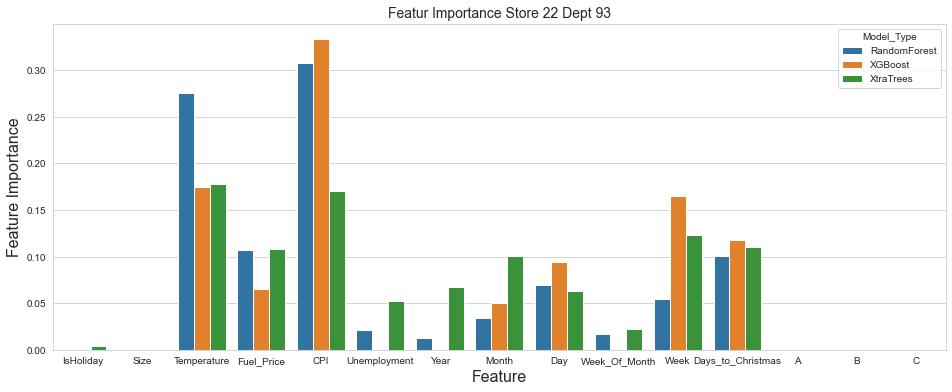

In [68]:
plt.figure(figsize=(16,6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Feature', y='Feature_Importtance', hue='Model_Type', data=df)

plt.title('Featur Importance Store {} Dept {}'.format(s,d), fontsize=14)
plt.ylabel('Feature Importance', fontsize=16)
plt.xlabel('Feature', fontsize=16)
plt.show()

In [17]:
pickle_model.feature_importances_


array([1.92872466e-01, 0.00000000e+00, 1.07546757e-01, 3.41525073e-02,
       1.85203729e-01, 1.92842731e-02, 1.78907819e-04, 3.39052628e-02,
       6.24610813e-02, 2.15493504e-02, 1.21468399e-01, 2.21377266e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [8]:
train_df_final.columns[3:]

Index(['IsHoliday', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'Year', 'Month', 'Day', 'Week_Of_Month', 'Week', 'Days_to_Christmas',
       'A', 'B', 'C'],
      dtype='object')

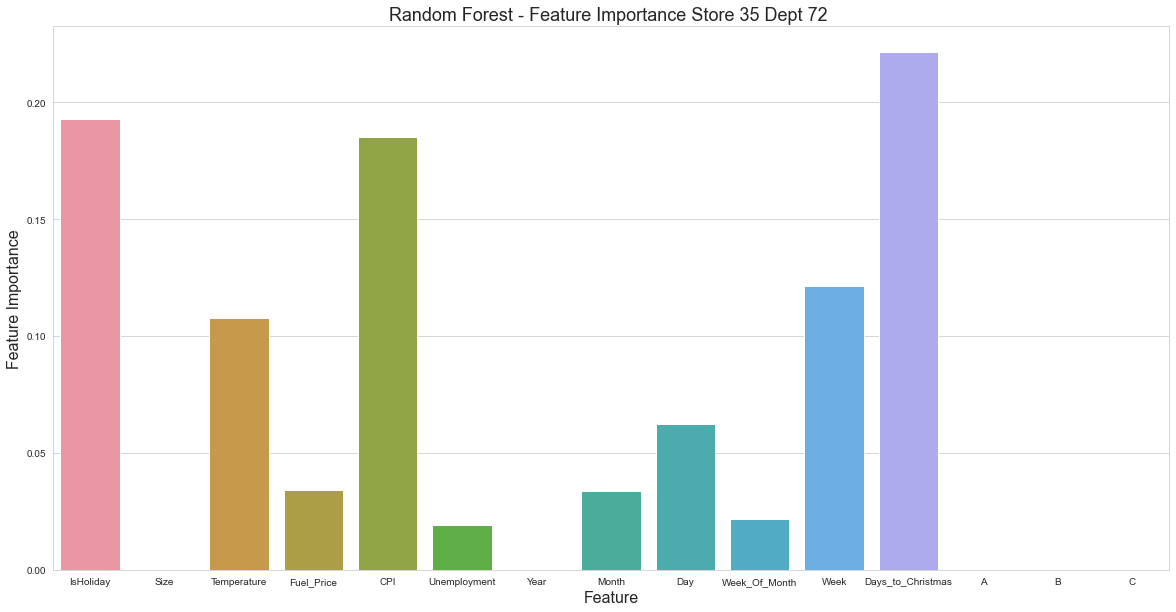

In [18]:
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=train_df_final.columns[3:], y=pickle_model.feature_importances_)
plt.title('Random Forest - Feature Importance Store 35 Dept 72 ', fontsize=18)
plt.ylabel('Feature Importance', fontsize=16)
plt.xlabel('Feature', fontsize=16)
plt.show()

In [38]:
weekly_sales_test[['Id','Weekly_Sales']].to_csv('Submissions/Submission_v16_All_VAll.csv', index=False);

## Result of Multiple models

In [1]:
from prettytable import PrettyTable 
myTable = PrettyTable(["Models", "Private Score", "Public Score"]) 

myTable.add_row(["Random Forest", "3089.84","2921.30448"]) 
myTable.add_row(["Average of 2 Random Forest", "3041.27575","2892.53128"]) 
myTable.add_row(["XGBoost", "3269.41583","3065.33341"])
myTable.add_row(["Average of XGBoost + Random Forest", "3269.41583","3065.33341"])
myTable.add_row(["ExtraTrees", "3123.98210","2946.12504"])
myTable.add_row(["Average of Random Forest + XGBoost + ExtraTrees", "2983.59973","2839.19310"])
myTable.add_row(["Prophet", "3073.71809","2966.65869"])
myTable.add_row(["Average of all models", "2770.29707","2639.92581"])

print(myTable)

+-------------------------------------------------+---------------+--------------+
|                      Models                     | Private Score | Public Score |
+-------------------------------------------------+---------------+--------------+
|                  Random Forest                  |    3089.84    |  2921.30448  |
|            Average of 2 Random Forest           |   3041.27575  |  2892.53128  |
|                     XGBoost                     |   3269.41583  |  3065.33341  |
|        Average of XGBoost + Random Forest       |   3269.41583  |  3065.33341  |
|                    ExtraTrees                   |   3123.98210  |  2946.12504  |
| Average of Random Forest + XGBoost + ExtraTrees |   2983.59973  |  2839.19310  |
|                     Prophet                     |   3073.71809  |  2966.65869  |
|              Average of all models              |   2770.29707  |  2639.92581  |
+-------------------------------------------------+---------------+--------------+


## Future Improvement 

1. I will try CNN LSTM based model for this problem